# Parse data from .txt or .csv files

In [72]:
import csv

def parse_txt(filename, oriented=True):
    """
    Parse data from txt file into dict python type.
    JSON serializable.
    """
    data = {}
    with open(filename) as file:
        
        line = file.readline()
        while line:
            
            # skip comments
            if line[0] == '#':
                line = file.readline()
                continue
            
            parent, child = line.split()
            parent = int(parent)
            child = int(child)
            
            # rows in data file can be duplicated
            if parent in data:
                if child not in data[parent]['linked']:
                    data[parent]['linked'].append(child)
                    data[parent]['degree'] += 1
            else:
                data[parent] = { 
                    'linked': [child],
                    'distances': {},
                    'degree': 1,
                    'centrality': 0,
                    'marked': False,
                    'active': True
                }
                
            if oriented:
                if child not in data:
                    data[child] = { 
                    'linked': [],
                    'distances': {},
                    'degree': 1,
                    'centrality': 0,
                    'marked': False,
                    'active': True
                }
                
            else:
                if child in data:
                    if parent not in data[child]['linked']:
                        data[child]['linked'].append(parent)
                        data[child]['degree'] += 1

                else:    
                    data[child] = {
                        'linked': [parent],
                        'distances': {},
                        'degree': 1,
                        'centrality': 0,
                        'marked': False,
                        'active': True
                    }

            line = file.readline()

    return data

def parse_csv(filename, oriented=True):
    data = {}
    
    with open(filename) as file:
        reader = csv.reader(file)
        next(reader)
        
        for row in reader:
            
            parent = int(row[0])
            child = int(row[1])
            
            if parent in data:
                if child not in data[parent]['linked']:
                    data[parent]['linked'].append(child)
                    data[parent]['degree'] += 1
            else:
                data[parent] = { 
                    'linked': [child],
                    'distances': {},
                    'degree': 1,
                    'centrality': 0,
                    'marked': False,
                    'active': True
                }
                
            if oriented:
                if child not in data:
                    data[child] = { 
                    'linked': [],
                    'distances': {},
                    'degree': 1,
                    'centrality': 0,
                    'marked': False,
                    'active': True
                }
                
            else:
                if child in data:
                    if parent not in data[child]['linked']:
                        data[child]['linked'].append(parent)
                        data[child]['degree'] += 1

                else:    
                    data[child] = {
                        'linked': [parent],
                        'distances': {},
                        'degree': 1,
                        'centrality': 0,
                        'marked': False,
                        'active': True
                    }
                    
    return data

def parse(filename, oriented=True):
    if filename.split('.')[-1] == 'txt':
        return parse_txt(filename, oriented)
    elif filename.split('.')[-1] == 'csv':
        return parse_csv(filename, oriented)

# Distance counting method with modifications

In [73]:
from collections import deque 
import datetime as dt

def count_distance(vertice, data, h = -1, full=False, rollback=True, monitoring=False):
    """
    Counts distances form given vertice to all other in connectivity component that vertice belongs to.
    Also, of h parameter is provided, this method finds list of vertices which are h or less away from provided vertice.
    (As only distance from provided vertive becomes more then h method stops.)
    Based on BFS.
    vertice: index of source vertice
    data: dict with information about graph
    h: distance to closest vertices
    fill: complete BFS in spite of current distance > h
    """

    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    current_distance = 0
    centrality = 0
    vertices_number = 1
    nearest_vertices = []
    d0 = deque()
    d1 = deque()
    
    source_active = data[vertice]['active']
    
    d0.append(vertice)
    data[vertice]['marked'] = True
    
    operations_counter += 9
    
    while True:
        
        if (not d0 and not d1) or (h != -1 and current_distance > h and not full):
            operations_counter += 9
            break
        
        if current_distance % 2 == 0:
            
            v = d0.pop()
                
            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d1.append(i)
                    data[i]['marked'] = True
                    
                    operations_counter += 2
                operations_counter += 2
            
            data[v]['distances'][vertice] = current_distance
            vertices_number += 1
            centrality += current_distance
            
            # set active to false if it vertice 'v' is too close to source vertice 'vertice'
            if h != -1 and current_distance <= h:
                data[v]['active'] = False
                nearest_vertices.append(v)
                
                operations_counter += 2
                
            # go to the next level of distance from the source vertice 'vertice'
            if not d0:
                current_distance += 1
                                
                operations_counter += 1
                
            operations_counter += 5 # number of "if"'s
                
        else:
            
            v = d1.pop()
                
            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d0.append(i)
                    data[i]['marked'] = True
                    
                    operations_counter += 2
                operations_counter += 2
            
            data[v]['distances'][vertice] = current_distance
            vertices_number += 1
            centrality += current_distance
            
            # set active to false if it vertice 'v' is too close to source vertice 'vertice'
            if h != -1 and current_distance <= h:
                data[v]['active'] = False
                nearest_vertices.append(v)
                
                operations_counter += 3
            
            # go to the next level of distance from the source vertice 'vertice'
            if not d1:
                current_distance += 1
                
                operations_counter += 1
                
            operations_counter += 5 # number of "if"'s added
    
    # rollback data
    if rollback:
        for key, value in data.items():
            value['marked'] = False
    
    # set initial status
    data[vertice]['active'] = source_active
    
    operations_counter =+ 1
    
    if full:
        data[vertice]['centrality'] = centrality / vertices_number
        operations_counter += 4
        
        if h == -1:
            if monitoring:
                return operations_counter, dt.datetime.now() - timestamp_before_algorithm
        else:
            if monitoring:
                return nearest_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return nearest_vertices
    else:
        if h == -1:
    
            data[vertice]['centrality'] = centrality / vertices_number
            operations_counter += 5
            
            if monitoring:
                return operations_counter, dt.datetime.now() - timestamp_before_algorithm
        else:
            if monitoring:
                return nearest_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return nearest_vertices

# Select landmarks using random, degree or centrality ranking

In [74]:
import random
from math import log
import datetime as dt

def select_landmarks(
    data: dict,
    number_of_landmarks = 0.1,
    ranking: str = 'degree',
    h: int = 1,
    rollback=False,
    monitoring=False
):
    """
    Select landmarks using constratined strategy with provided h and ranking parameters.
    Set h to -1 to get top 'number_of_landmarks' ranked vertices.
    Possible ranking: degree, random, closeness.
    Set rollback to True to roll back all vertices 'active' to True
    """
    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    data_items = data.items()
    graph_size = len(data_items)
#     print('=' * 126)
#     print('Graph size: ' + str(graph_size))
    
    number_of_landmarks = int(
        graph_size * (number_of_landmarks / 100)
    ) if number_of_landmarks >= 1 else int(
        graph_size * number_of_landmarks
    )
    
#     print('=' * 126)
#     print('Target number of landmarks: ' + str(number_of_landmarks))
    
    landmarks = []
    
    operations_counter += graph_size + 5
    
    
    if ranking == 'random':
        
        vertices = [i[0] for i in data_items]
        if h == -1:
            
            random_vertices = [vertices[i] for i in random.sample(range(0,graph_size), number_of_landmarks)]
            
            for v in vertices:
                operations, __ = count_distance(vertice=v, data=data, h=-1, full=True, monitoring=True)
                operations_counter += operations + 1
            
            operations_counter += 1 + number_of_landmarks
            
            if monitoring:
                return random_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return random_vertices

        operations_counter += len(data_items) + number_of_landmarks
        
        random.shuffle(vertices)
        
        operations_counter += len(vertices)
        
        while len(landmarks) < number_of_landmarks and vertices:
            
            v = vertices.pop(0)
            
            # check if vertice 'v' is less than 'h' away from some previously selected landmark
            if not data[v]['active']:
                continue
            
            landmarks.append(v)
            _, operations, __ = count_distance(vertice=v, data=data, h=h, full=True, monitoring=True)
            
            operations_counter += operations + 3
    
    
    elif ranking == 'degree':
        
        data_sorted = sorted(data_items, key=lambda x: x[1]['degree'], reverse=True)
        
        operations_counter += graph_size * log(graph_size)
        
        if h == -1:
            
            max_degree_vertices = [i[0] for i in data_sorted[:number_of_landmarks]]
            
            for v in max_degree_vertices:
                operations, __ = count_distance(vertice=v, data=data, h=-1, full=True, monitoring=True)
                operations_counter += operations + 1
            
            operations_counter += 2 * number_of_landmarks + 1
            if monitoring:
                return max_degree_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return max_degree_vertices
        
        while len(landmarks) < number_of_landmarks and data_sorted:
            v = data_sorted.pop(0)[0]
            
            # check if vertice 'v' is less than 'h' away from some previously selected landmark
            if not data[v]['active']:
                continue
                
            landmarks.append(v)
            _, operations, __ = count_distance(vertice=v, data=data, h=h, full=True, monitoring=True)
            
            operations_counter += operations + 3
            
    
    elif ranking == 'closeness':
        
        shuffled_vertices = [i[0] for i in data_items]
        random.shuffle(shuffled_vertices)
        
        number_of_seeds = int(
            number_of_landmarks + (graph_size - number_of_landmarks) / 2
        ) if number_of_landmarks >= (graph_size / 2) else number_of_landmarks * 2
#         print('=' * 126)
#         print('Number of seeds: ' + str(number_of_seeds))
        
        operations_counter += 2 * graph_size + 6
        
        if h == -1:
            
            seeds = []
            while len(seeds) < number_of_seeds and shuffled_vertices:
                seed = shuffled_vertices.pop(0)
                if data[seed]['linked']:
                    operations, __ = count_distance(vertice=seed, data=data, h=-1, full=True, monitoring=True)
                    seeds.append(seed)
                    
                    operations_counter += operations + 1
                operations_counter += 1
                
            # select top 'number_of_landmarks' vertices with lowest closeness centrality
            min_centrality_vertices = [
                i[0] for i in sorted(
                    [(key, value['centrality']) for key, value in data.items() if key in seeds],
                    key=lambda x: x[1]
                )[:number_of_landmarks]
            ]
            
            operations_counter += len(seeds) + log(len(seeds)) * len(seeds)
            if monitoring:
                return min_centrality_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return min_centrality_vertices
        
        
        seeds = []
        while len(seeds) < number_of_seeds and shuffled_vertices:
            seed = shuffled_vertices.pop(0)
            if data[seed]['linked']:
                _, operations, __ = count_distance(vertice=seed, data=data, h=h, full=True, monitoring=True)
                seeds.append(seed)
                
                operations_counter += operations + 1
            operations_counter += 1

        # sort seeds by closeness centrality
        seeds_sorted = [
            i[0] for i in sorted(
                [(key, value['centrality']) for key, value in data.items() if key in seeds],
                key=lambda x: x[1]
            )
        ]
        
#         for s in seeds_sorted:
#             print(str(s))
#             print(data[s]['centrality'])
#             print(data[s]['linked'])
#             print()
            
#         print('=' * 100)
        
        landmarks.append(seeds_sorted.pop(0))
#         print(str(landmarks[0]) + ': ' + str(data[landmarks[0]]['active']))

        operations_counter += graph_size + len(seeds) * log(len(seeds))

        while len(landmarks) < number_of_landmarks:
            
            if not seeds_sorted:
#                 print('=' * 126)
#                 print('For unsortet vertices: ')
#                 print("Number of landmarks after iteration by sorted seeds: " + str(len(landmarks)))
#                 print('=' * 126)

                # iteration by remaining shuffled vertices
                for seed in shuffled_vertices:
                    if len(landmarks) >= number_of_landmarks:
                        break
                    if data[seed]['active']:
                        _, operations, __ = count_distance(vertice=seed, data=data, h=h, full=True, monitoring=True)
                        landmarks.append(seed)
                        operations_counter += operations + 1
                    
                    operations_counter += 2
                break
            
            landmarks.append(seeds_sorted.pop(0))
       
            operations_counter += 3
    
#     print('Target number of landmarks: ' + str(number_of_landmarks))
#     print('Number of calculated landmarks: ' + str(len(landmarks)))
            
    # data rollback
    if rollback:
        for key, value in data.items():
            value['active'] = True
                
    if monitoring:
        landmarks, operations_counter, dt.datetime.now() - timestamp_before_algorithm
    return landmarks

# BFS

In [75]:
import datetime as dt

def bfs(source, stock, data, rollback=True, monitoring=False):
    """
    Count distance from source to stock without using landmarks.
    Pure BFS.
    """
    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    if not all(key in data for key in (source, stock)):
        print('Key not found')
        operations_counter += 2 * len(data.items())
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1
    
    current_distance = 0
    flag_found = False
    d0 = deque()
    d1 = deque()
    
    d0.append(source)
    data[source]['marked'] = True
    
    operations_counter += 7
    
    while True:
        
        if not d0 and not d1:
            current_distance = -1
            
            operations_counter += 3
            break
        
        if current_distance % 2 == 0:
            
            v = d0.pop()
            
            if v == stock:
                flag_found = True
                
                operations_counter += 1
                break
                
            for i in data[v]['linked']: 
                if not data[i]['marked']:
                    d1.append(i)
                    data[i]['marked'] = True
                    
                    operations_counter += 2
                operations_counter += 2
            
            if not d0:
                current_distance += 1
                
                operations_counter += 1
                
            operations_counter += 3
                
        else:
            
            v = d1.pop()
            
            if v == stock:
                flag_found = True
                break
                
            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d0.append(i)
                    data[i]['marked'] = True
                    
                    operations_counter += 2
                operations_counter += 2
            
            if not d1:
                current_distance += 1 
                
                operations_counter += 1
            
            operations_counter += 3
    
    if rollback:
        for key, value in data.items():
            value['marked'] = False

    if flag_found:
        if monitoring:
            return current_distance, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return current_distance
    else:
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1

# Shortest path estimating via landmarks method

In [76]:
import datetime as dt

def shortest_path(
    source,
    stock,
    landmarks,
    data,
    estimation_strategy='geometrical_mean',
    monitoring=False
):
    """
    Counts distance from source to stock using landmarks.
    For distance estimation geometric mean is used.
    There are 4 estimation strategies: geometrical mean, upper, lower and middle point. Geometrical mean is default.
    """
    
    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    # source or stock not in graph
    try:
        source_distances = data[source]['distances']
        stock_distances = data[stock]['distances']
    except KeyError:
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1
    
    L = -1
    U = 3 * len(data.items())
    
    operations_counter += 5
    
#     for landmark in landmarks:
    for key, to_source in source_distances.items():
        
        # use distances only to landmarks
        
#         to_source = source_distances.get(landmark, -1)
#         to_stock = stock_distances.get(landmark, -1)
#         if to_source == -1 or to_stock == -1:
#             continue
        to_stock = stock_distances.get(key, -1)
        if to_stock == -1:
            continue
        
        l = abs(to_source - to_stock)
        u = to_source + to_stock
        
        if l > L:
            L = l
            operations_counter += 1
        if u < U:
            U = u
            operations_counter += 1
            
        operations_counter += 9 + len(landmarks)
            
    if L == -1 and U == 3 * graph_size:
        # this mean that source and stock are in different connectivity components
        
        operations_counter += 3
        
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1
    
    # choose estimating strategy
    if estimation_strategy == 'geometrical_mean':
        result = (L * U) ** 0.5
    elif estimation_strategy == 'middle_point':
        result = (L + U) / 2
    elif estimation_strategy == 'upper':
        result = U
    elif estimation_strategy == 'lower':
        result = L
    else:
        result = (L * U) ** 0.5
    
    if monitoring:
        return result, operations_counter, dt.datetime.now() - timestamp_before_algorithm
    return result

# Environment variables

In [96]:
FILENAME = 'test-vk.csv'
ORIENTED = False
LANDMARKS_PERCENT = 10
TEST_VERTICES_PERCENT = 10

In [25]:
# data = parse(FILENAME, ORIENTED)

# count_distance(vertice=356332, data=data, full=True, monitoring=True)

# print(data[356332])

# landmarks = select_landmarks(data, LANDMARKS_PERCENT, ranking='degree', rollback=True)
# landmarks = select_landmarks(data, LANDMARKS_PERCENT, ranking='closeness', rollback=True)
# print(landmarks)

119755
0.3333333333333333
[177631]

668992
0.3333333333333333
[546100]

55948
0.3333333333333333
[666882]

504263
0.3333333333333333
[31180]

12
0.3333333333333333
[844958]

16586
0.3333333333333333
[179147]

43847
0.3333333333333333
[711582]

44788
0.3333333333333333
[243547]

99387
0.3333333333333333
[498736]

130698
0.3333333333333333
[571169]

390257
0.3333333333333333
[322785]

422877
0.3333333333333333
[118607]

451817
0.3333333333333333
[562164]

460382
0.3333333333333333
[518754]

567443
0.3333333333333333
[372067]

639906
0.3333333333333333
[610200]

661693
0.3333333333333333
[668845]

771890
0.3333333333333333
[523930]

795462
0.3333333333333333
[663461]

859227
0.3333333333333333
[308153]

888999
0.3333333333333333
[701637]

316341
0.3333333333333333
[839729]

854445
0.3333333333333333
[187829]

268960
0.3333333333333333
[867231]

533825
0.3333333333333333
[902762]

664116
0.3333333333333333
[902762]

217042
0.3333333333333333
[445867]

12976
0.3333333333333333
[151110]

292

In [98]:
data = parse(FILENAME, ORIENTED)
for key, value in data.items():
    count_distance(key, data, rollback=True)
print(data)

{3248374: {'linked': [11431799], 'distances': {3248374: 0, 11431799: 1}, 'degree': 1, 'centrality': 0.3333333333333333, 'marked': False, 'active': True}, 11431799: {'linked': [3248374], 'distances': {3248374: 1, 11431799: 0}, 'degree': 1, 'centrality': 0.3333333333333333, 'marked': False, 'active': True}, 3429130: {'linked': [4795235], 'distances': {3429130: 0, 4795235: 1}, 'degree': 1, 'centrality': 0.3333333333333333, 'marked': False, 'active': True}, 4795235: {'linked': [3429130], 'distances': {3429130: 1, 4795235: 0}, 'degree': 1, 'centrality': 0.3333333333333333, 'marked': False, 'active': True}, 105512: {'linked': [8910840], 'distances': {105512: 0, 8910840: 1}, 'degree': 1, 'centrality': 0.3333333333333333, 'marked': False, 'active': True}, 8910840: {'linked': [105512], 'distances': {105512: 1, 8910840: 0}, 'degree': 1, 'centrality': 0.3333333333333333, 'marked': False, 'active': True}, 7900466: {'linked': [9739979], 'distances': {7900466: 0, 9739979: 1}, 'degree': 1, 'centralit

In [95]:
# data = parse('test-google.txt', True)
count_distance(84424, data)
print(data[84424])
print('=' * 100)
# print(data[11342])
# print('=' * 100)
# print(data[867923])
# print('=' * 100)
# print(data[891835])
# print('=' * 100)
# print(bfs(0, 760842 , data))

{'linked': [276, 1662, 5089, 6058, 6229, 10639, 16442, 19325, 19834, 20113, 21937, 25452, 26902, 29829, 30222, 32432, 33040, 39238, 39521, 41418, 45009, 45098, 45242, 47005, 47968, 47999, 49934, 50220, 50897, 51730, 53681, 57537, 58458, 59326, 61571, 63552, 64124, 64568, 66200, 69839, 72391, 73543, 76259, 77098, 77915, 78627, 83560, 85420, 88768, 89131, 89308, 89994, 90506, 91060, 92387, 93296, 94138, 94329, 95070, 95531, 96570, 97101, 98506, 99104, 104802, 106611, 107829, 109016, 112605, 117751, 122908, 124023, 125190, 130825, 132445], 'distances': {74612: 2, 27862: 3, 104589: 4, 98621: 3, 47128: 3, 68363: 3, 18344: 3, 23986: 2, 27124: 3, 110210: 3, 127816: 3, 131234: 3, 10426: 3, 84424: 0, 57961: 3, 100394: 3, 1513: 3, 51588: 3, 99023: 3, 38861: 3, 44011: 2, 103169: 3, 55066: 3, 30864: 4, 8445: 2, 63707: 2, 113138: 2, 80218: 3, 31334: 3, 26526: 2, 61461: 2, 12494: 3, 30422: 3, 49689: 3, 2158: 3, 93889: 2, 96909: 2, 127225: 3, 18007: 3, 87214: 2, 101953: 2, 112903: 3, 70950: 3, 106274

# Calculate test results

In [92]:
import random

data = parse(FILENAME, ORIENTED)
graph_size = len(data.items())

select_strategies = ('random', 'degree', 'closeness')
estimation_strategies = ('geometrical_mean', 'middle_point', 'upper', 'lower')

test_vertices_number = int(
    graph_size * (TEST_VERTICES_PERCENT / 100)
) if TEST_VERTICES_PERCENT > 1 else int(
    graph_size * TEST_VERTICES_PERCENT
)

results = {
    'random': {
        'geometrical_mean': [],
        'middle_point': [],
        'upper': [],
        'lower': []
    },
    'degree': {
        'geometrical_mean': [],
        'middle_point': [],
        'upper': [],
        'lower': []
    },
    'closeness': {
        'geometrical_mean': [],
        'middle_point': [],
        'upper': [],
        'lower': []
    }
}

vertices = [i[0] for i in data.items()]
vertices_source = vertices.copy()
random.shuffle(vertices_source)
vertices_source = vertices_source[:test_vertices_number]

vertices_stock = vertices.copy()
random.shuffle(vertices_stock)
vertices_stock = vertices_stock[:test_vertices_number]

# count test results for each type of calculation
for select in select_strategies:
    
    landmarks = select_landmarks(data, LANDMARKS_PERCENT, ranking=select, monitoring=True, rollback=True)
    
    for estimation in estimation_strategies:
        
        print('=' * 125)
        print(select)
        print(estimation)
        
        
        for source, stock in zip(vertices_source,vertices_stock):
            
            print('=' * 125)
            print('Source: ' + str(source))
            print('Stock: ' + str(stock))

            distance_bfs, operations_bfs, time_bfs = bfs(source, stock, data, monitoring=True)
            
            distance_landmarks, operations_landmarks, time_landmarks = shortest_path(
                source, stock, landmarks, data, estimation_strategy=estimation, monitoring=True
            )
            
            print('Distance BFS:' + str(distance_bfs))
            print('Distance Landmarks: ' + str(distance_landmarks))
            
            accuracy = abs(distance_bfs - distance_landmarks)
            operation_delta = abs(operations_bfs - operations_landmarks)
            time_delta = abs(time_bfs - time_landmarks)
            
            print('Accuracy: ' + str(accuracy))
            print('Operations delta: ' + str(operation_delta))
            print('Operating time delta: ' + str(time_delta))

            results[select][estimation].append((accuracy, operation_delta, time_delta))

random
geometrical_mean
Source: 63707
Stock: 29829
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 1066
Operating time delta: 0:00:00
Source: 30625
Stock: 68639
Distance BFS:4
Distance Landmarks: 3.4641016151377544
Accuracy: 0.5358983848622456
Operations delta: 1224
Operating time delta: 0:00:00.001000
Source: 29606
Stock: 33777
Distance BFS:4
Distance Landmarks: 3.4641016151377544
Accuracy: 0.5358983848622456
Operations delta: 1351
Operating time delta: 0:00:00
Source: 31404
Stock: 92357
Distance BFS:4
Distance Landmarks: 3.1622776601683795
Accuracy: 0.8377223398316205
Operations delta: 1366
Operating time delta: 0:00:00.001000
Source: 10639
Stock: 21937
Distance BFS:2
Distance Landmarks: 1.4142135623730951
Accuracy: 0.5857864376269049
Operations delta: 1152
Operating time delta: 0:00:00
Source: 61686
Stock: 30400
Distance BFS:5
Distance Landmarks: 4.242640687119285
Accuracy: 0.7573593128807152
Operations delta: 1884
Operating time delta: 0:00:00
Source: 3365
St

Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 1328
Operating time delta: 0:00:00
Source: 117751
Stock: 30502
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 664
Operating time delta: 0:00:00
Source: 106763
Stock: 132766
Distance BFS:5
Distance Landmarks: 5
Accuracy: 0
Operations delta: 789
Operating time delta: 0:00:00.001000
Source: 51604
Stock: 47999
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 2772
Operating time delta: 0:00:00
Source: 121461
Stock: 15829
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 1699
Operating time delta: 0:00:00
Source: 30422
Stock: 87214
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 1276
Operating time delta: 0:00:00.001001
Source: 89994
Stock: 68577
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 1613
Operating time delta: 0:00:00
Source: 113825
Stock: 42994
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 1110
Operatin

Source: 89994
Stock: 68577
Distance BFS:4
Distance Landmarks: 2
Accuracy: 2
Operations delta: 4993
Operating time delta: 0:00:00
Source: 113825
Stock: 42994
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 4491
Operating time delta: 0:00:00
Source: 74612
Stock: 28516
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 7171
Operating time delta: 0:00:00
Source: 10976
Stock: 105827
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 6742
Operating time delta: 0:00:00
Source: 51730
Stock: 120586
Distance BFS:5
Distance Landmarks: 5
Accuracy: 0
Operations delta: 3796
Operating time delta: 0:00:00
Source: 91401
Stock: 97012
Distance BFS:5
Distance Landmarks: 3
Accuracy: 2
Operations delta: 4302
Operating time delta: 0:00:00
Source: 25095
Stock: 122460
Distance BFS:3
Distance Landmarks: 1
Accuracy: 2
Operations delta: 7236
Operating time delta: 0:00:00
Source: 44022
Stock: 9039
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 

In [41]:
print(bfs(86122, 93, data))

-1


In [48]:
# print(824020 in landmarks)
print(data)

{0: {'linked': [11342, 824020, 867923, 891835], 'distances': {11342: 1, 824020: 1, 867923: 1, 891835: 1, 0: 0}, 'degree': 4, 'centrality': 1.7714285714285714, 'marked': False, 'active': True}, 11342: {'linked': [0, 27469, 38716, 309564, 322178, 387543, 427436, 538214, 638706, 645018, 835220, 856657, 867923, 891835], 'distances': {11342: 0, 824020: 2, 867923: 1, 891835: 1, 0: 1}, 'degree': 15, 'centrality': 1.6, 'marked': False, 'active': True}, 824020: {'linked': [0, 91807, 322178, 387543, 417728, 438493, 500627, 535748, 695578, 867923, 891835], 'distances': {11342: 2, 824020: 0, 867923: 2, 891835: 2, 0: 1}, 'degree': 12, 'centrality': 1.8, 'marked': False, 'active': True}, 867923: {'linked': [0, 11342, 136593, 414038, 500627, 523684, 760842, 815602, 835220, 846213, 857527, 891835], 'distances': {11342: 1, 824020: 1, 867923: 0, 891835: 1, 0: 1}, 'degree': 13, 'centrality': 1.6571428571428573, 'marked': False, 'active': True}, 891835: {'linked': [0, 11342, 112028, 235849, 302284, 417728

# Transform data into convenient for plotting format and calculating tracked values

In [31]:
from statistics import mean

plot_data = {
    'random': {
        'beans': [],
        'accuracy': [],
        'time_delta': [],
        'operations_delta': []
    },
    'degree': {
        'beans': [],
        'accuracy': [],
        'time_delta': [],
        'operations_delta': []
    },
    'closeness': {
        'beans': [],
        'accuracy': [],
        'time_delta': [],
        'operations_delta': []
    }
}

for key, value in results.items():
    for i, j in value.items():
            
        sum_accuracy = 0
        sum_operations_delta = 0
        sum_time_delta = 0
        for t in j:
            sum_accuracy += t[0]
            sum_operations_delta += t[1]
            sum_time_delta += t[2].total_seconds() * 1000  # in milliseconds
            
        plot_data[key]['beans'].append(i)
        plot_data[key]['accuracy'].append(sum_accuracy / len(j))
        plot_data[key]['time_delta'].append(sum_time_delta / len(j))
        plot_data[key]['operations_delta'].append(sum_operations_delta / len(j))

print(plot_data)


ZeroDivisionError: division by zero

# Plotting

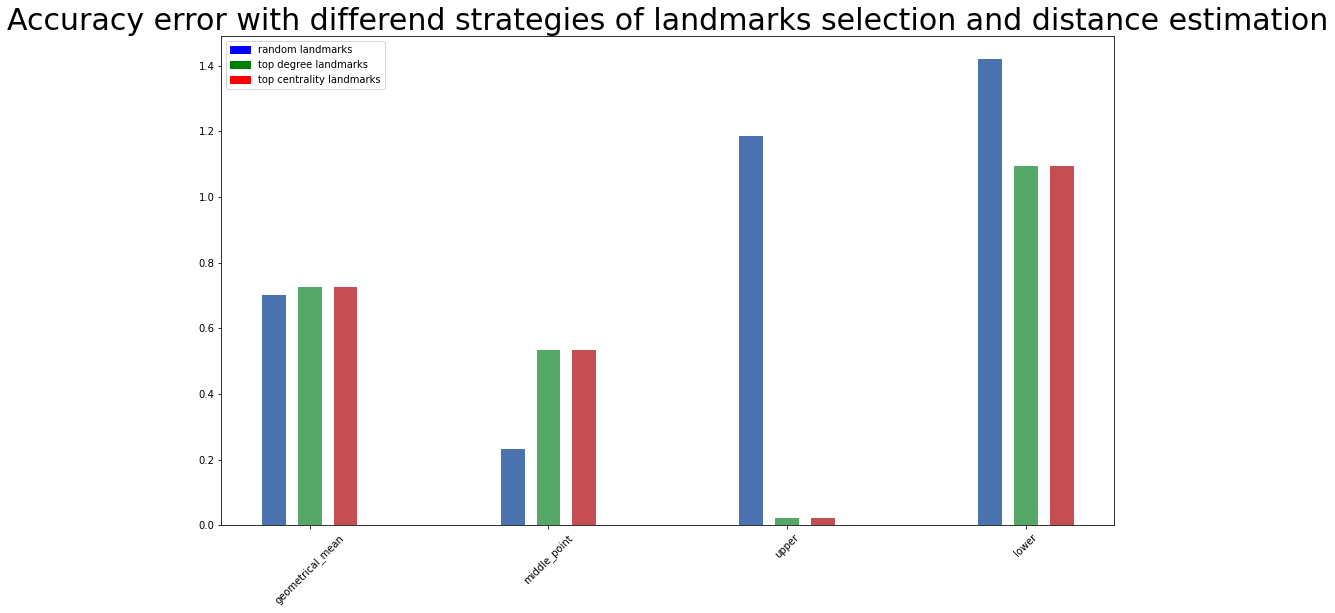

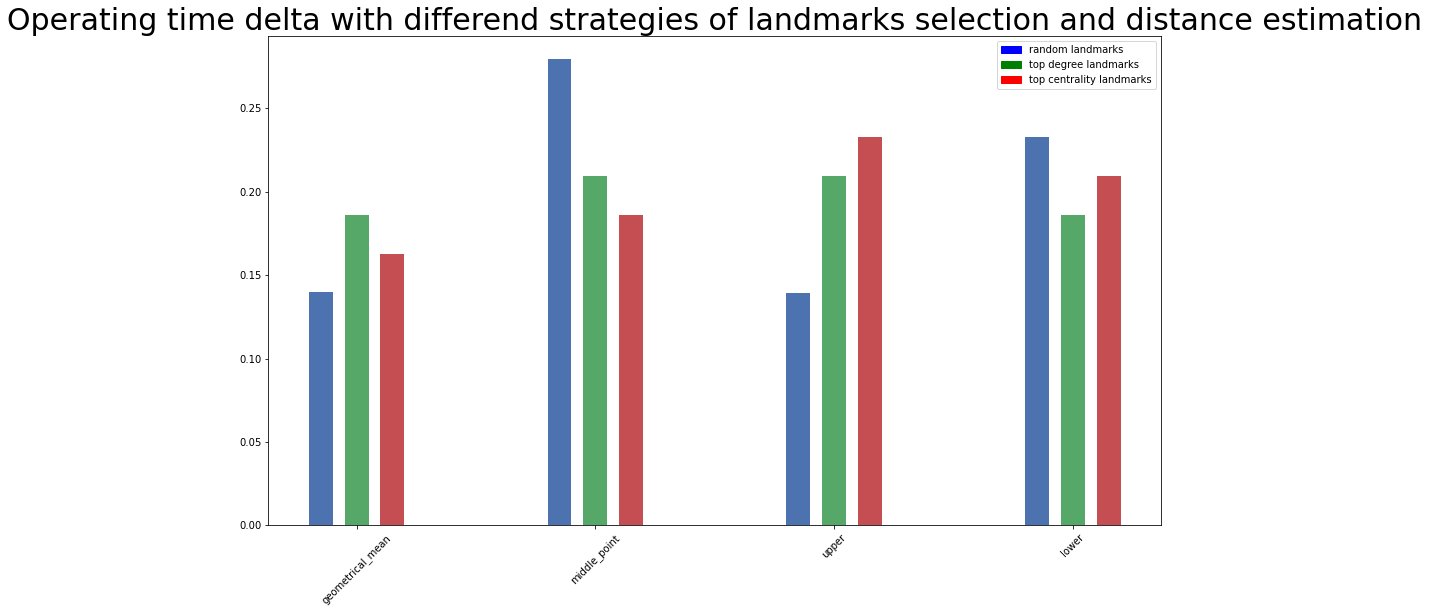

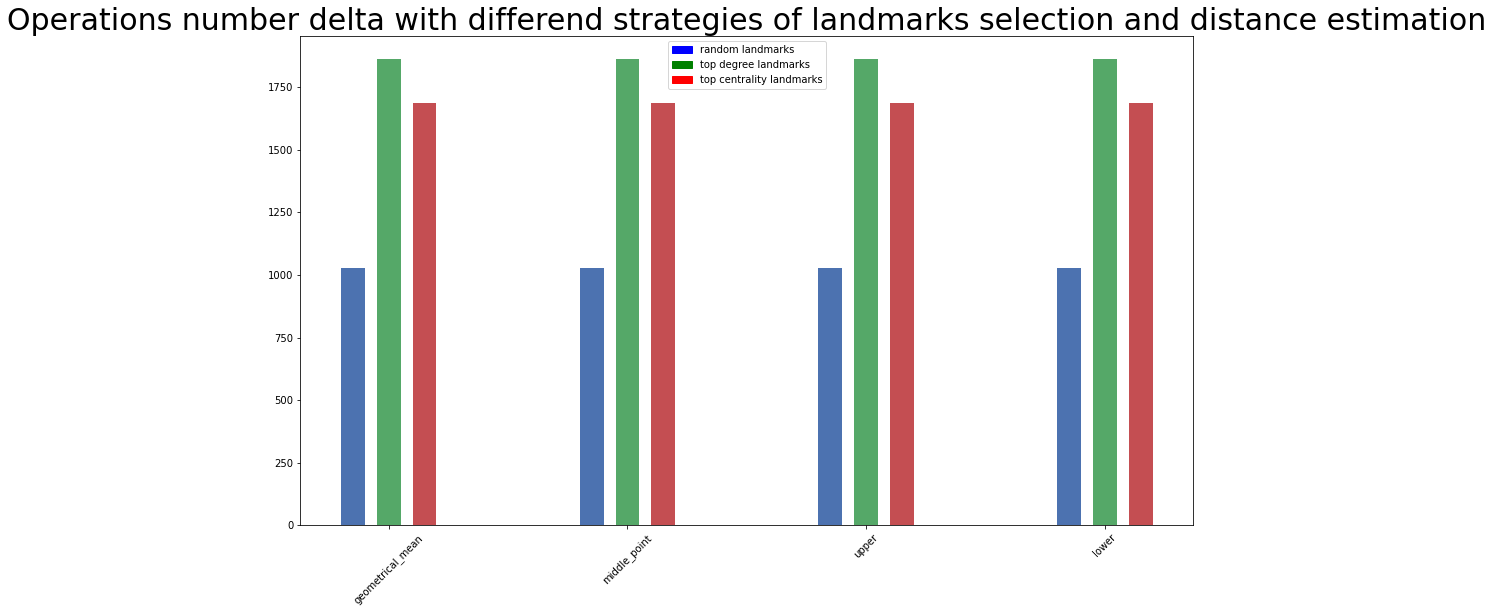

In [169]:
import matplotlib.pyplot as plt
import numpy as np


labels = plot_data['random']['beans']  # choose any landmark selecting strategy
colors = {'random landmarks': 'blue', 'top degree landmarks': 'green', 'top closeness landmarks': 'red'}


# Accuracy error

plt.figure(figsize=(16,9))

y1 = plot_data['random']['accuracy']
y2 = plot_data['degree']['accuracy']
y3 = plot_data['closeness']['accuracy']

plt.bar(np.arange(len(labels)) - 0.15, y1, align='center', width = 0.1)
plt.bar(np.arange(len(labels)), y2, align='center', width = 0.1)
plt.bar(np.arange(len(labels)) + 0.15, y3, align='center', width = 0.1)

plt.xticks(range(len(labels)), labels, rotation=45)

plt.title('Accuracy error with differend strategies of landmarks selection and distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

plt.savefig('accuracy_error.jpg', dpi=100, bbox_inches='tight')
plt.show()


# Operating time delta

plt.figure(figsize=(16,9))

y1 = plot_data['random']['time_delta']
y2 = plot_data['degree']['time_delta']
y3 = plot_data['closeness']['time_delta']

plt.bar(np.arange(len(labels)) - 0.15, y1, align='center', width = 0.1)
plt.bar(np.arange(len(labels)), y2, align='center', width = 0.1)
plt.bar(np.arange(len(labels)) + 0.15, y3, align='center', width = 0.1)

plt.xticks(range(len(labels)), labels, rotation=45)

plt.title('Operating time delta with differend strategies of landmarks selection and distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

plt.savefig('operating_time_delta.jpg', dpi=100, bbox_inches='tight')
plt.show()


# Operations number delta

plt.figure(figsize=(16,9))

y1 = plot_data['random']['operations_delta']
y2 = plot_data['degree']['operations_delta']
y3 = plot_data['closeness']['operations_delta']

plt.bar(np.arange(len(labels)) - 0.15, y1, align='center', width = 0.1)
plt.bar(np.arange(len(labels)), y2, align='center', width = 0.1)
plt.bar(np.arange(len(labels)) + 0.15, y3, align='center', width = 0.1)

plt.xticks(range(len(labels)), labels, rotation=45)

plt.title('Operations number delta with differend strategies of landmarks selection and distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

plt.savefig('operations_number_delta.jpg', dpi=100, bbox_inches='tight')
plt.show()